In [1]:
import pandas as pd
import numpy as np
import os
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler

In [2]:
# load functional measures
FC_data = pd.read_csv('raw_data/ukbb_FC_data.csv').dropna(how='any')

In [3]:
# load global structural measures
global_data = pd.read_csv('raw_data/global_brain_measures.csv').dropna(how='any')

# load scanning positions x,y,z
pos_data = pd.read_csv('raw_data/scanning_positions.csv').dropna(how='any')

# load covariates 
age_sex = pd.read_csv('raw_data/ukbb_age_sex.csv').dropna(how='any')
cols = ['eid']
for i in range(25):
    cols.append('PC'+str(i+1))
PCs = pd.read_csv('raw_data/top_100_PCs.csv')[cols].dropna(how='any')

In [4]:
# load rsfMRI head motions
motions = pd.read_csv('raw_data/ukbb_rsfMRI_head_motions.csv').dropna(how='any')

In [5]:
# load PRS data
PRS_data = pd.read_csv('raw_data/multi_PRSs.csv').dropna(how='any')

In [6]:
# merge data
FC_data.set_index('eid',inplace=True)
global_data.set_index('eid',inplace=True)
pos_data.set_index('eid',inplace=True)
age_sex.set_index('eid',inplace=True)
PCs.set_index('eid',inplace=True)
motions.set_index('eid',inplace=True)
PRS_data.set_index('eid',inplace=True)

l = list(set(FC_data.index) & set(motions.index) & set(global_data.index) & set(pos_data.index) \
         & set(age_sex.index) & set(PCs.index) & set(PRS_data.index))

final_FC = FC_data.loc[l]
final_global_measures = global_data.loc[l]
final_pos = pos_data.loc[l]
final_age_sex = age_sex.loc[l]
final_PCs = PCs.loc[l]
final_motions = motions.loc[l]
final_PRSs = PRS_data.loc[l]

final_FC.reset_index(inplace=True)
final_global_measures.reset_index(inplace=True)
final_pos.reset_index(inplace=True)
final_age_sex.reset_index(inplace=True)
final_PCs.reset_index(inplace=True)
final_motions.reset_index(inplace=True)
final_PRSs.reset_index(inplace=True)

In [7]:
# create covariates
ACT = final_global_measures.iloc[:,3:4].values
TCSA = final_global_measures.iloc[:,2:3].values
ICV = final_global_measures.iloc[:,1:2].values

PCs_25 = final_PCs.iloc[:,1:].values
age = final_age_sex.iloc[:,2:3].values
sex = final_age_sex.iloc[:,1:2].values
postions = final_pos.iloc[:,1:].values
head_motion = final_motions.iloc[:,1:2].values
sex = sex + 1

co = np.hstack((PCs_25,age,sex,age*age,age*sex,age*age*sex,postions,head_motion))

In [8]:
# function used for regressing out the effects of covariates 
def regression_covariant(covariant_matrix, y, standard_scale=False):
    a = np.hstack((covariant_matrix,np.ones((covariant_matrix.shape[0], 1))))
    w = np.linalg.lstsq(a,y,rcond=None)[0]

    residual = y - covariant_matrix.dot(w[:-1])
    residual = residual.astype('float64')

    if standard_scale:
        residual = StandardScaler().fit_transform(residual.reshape(-1,1)).flatten()

    return residual, w

In [11]:
from scipy import stats

def pearsonr_ci(x,y,alpha=0.05):
    ''' calculate Pearson correlation along with the confidence interval using scipy and numpy
    Parameters
    ----------
    x, y : iterable object such as a list or np.array
      Input for correlation calculation
    alpha : float
      Significance level. 0.05 by default
    Returns
    -------
    r : float
      Pearson's correlation coefficient
    pval : float
      The corresponding p value
    lo, hi : float
      The lower and upper bound of confidence intervals
    '''

    r, p = stats.pearsonr(x,y)
    r_z = np.arctanh(r)
    se = 1/np.sqrt(x.size-3)
    z = stats.norm.ppf(1-alpha/2)
    lo_z, hi_z = r_z-z*se, r_z+z*se
    lo, hi = np.tanh((lo_z, hi_z))
    return r, p, lo, hi

In [12]:
def correlation_analysis(X,Y,co):
    re_R = np.empty((X.shape[1],Y.shape[1]))
    re_P = np.empty((X.shape[1],Y.shape[1]))
    Low = np.empty((X.shape[1],Y.shape[1]))
    High = np.empty((X.shape[1],Y.shape[1]))
    for i in range(X.shape[1]):
        for j in range(Y.shape[1]):
            x = X[:,i]
            y = Y[:,j]
            [rx,w1] = regression_covariant(co,x,standard_scale=True)
            [ry,w1] = regression_covariant(co,y,standard_scale=True)
            r,p,lo,hi = pearsonr_ci(rx, ry)
            re_R[i,j] = r
            re_P[i,j] = p
            Low[i,j] = lo
            High[i,j] = hi
    return re_R,re_P,Low,High

In [13]:
X = final_PRSs.iloc[:,1:].values
X[:,7] = -X[:,7]
X[:,8] = -X[:,8]
X[:,11] = -X[:,11]

Y = final_FC.iloc[:,1:].values

In [14]:
R,P,Low, High = correlation_analysis(X,Y,co)

In [15]:
def output_CIs(Low,High,output_path):
    s = Low.shape
    for i in range(s[0]):
        tmp = []
        for j in range(s[1]):
            lo = round(Low[i,j], 4)
            hi = round(High[i,j], 4)
            tmp.append('(' + str(lo) + ' , ' + str(hi) + ')')
        if i == 0:
            data = pd.DataFrame(data=tmp,columns=[str(i+1)])
        else:
            data[str(i+1)] = tmp
    output_file = output_path + '_CIs.csv'
    data.to_csv(output_file,index=False)

In [17]:
output_CIs(Low, High,'results/functional_measures/FC')

In [23]:
from statsmodels.stats import multitest

def fdr_correction(P):
    size = P.shape
    temp_p = P.flatten()
    Ps = multitest.multipletests(temp_p,alpha=0.05,method='fdr_bh')
    P_corrected = Ps[1].reshape(size)
    return P_corrected

/data/sliu/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [24]:
correct_P = fdr_correction(P)

In [26]:
# output results
data1 = pd.DataFrame(data=R)
data1.to_csv('results/functional_measures/FC_R.csv',header=None,index=False)
data2 = pd.DataFrame(data=P)
data2.to_csv('results/functional_measures/FC_P.csv',header=None,index=False)
data3 = pd.DataFrame(data=correct_P)
data3.to_csv('results/functional_measures/FC_P_corrected.csv',header=None,index=False)

In [27]:
PRS_names = final_PRSs.columns.values[1:]

In [28]:
import matplotlib.pyplot as plt
from mne.viz import circular_layout, plot_connectivity_circle
from matplotlib import colors as mcolors
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
label_names = []
for i in range(21):
    label_names.append(i+1)
colors = list(mcolors.CSS4_COLORS.values())
selected_colors = colors[15:36]
selected_colors[9] = colors[37]
selected_colors[3] = colors[40]
selected_colors[5] = colors[41]
selected_colors[1] = colors[48]
selected_colors[13] = colors[46]

ADHD_2017 5


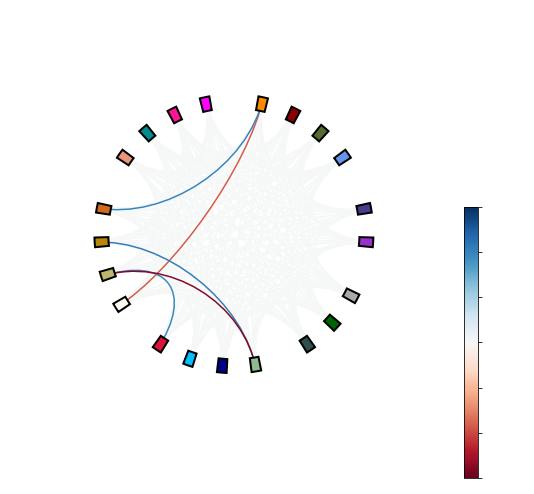

alzheimer 0
autism 8


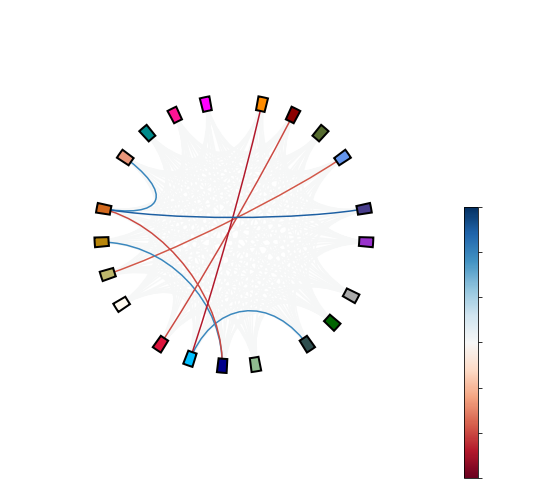

bipolar 5


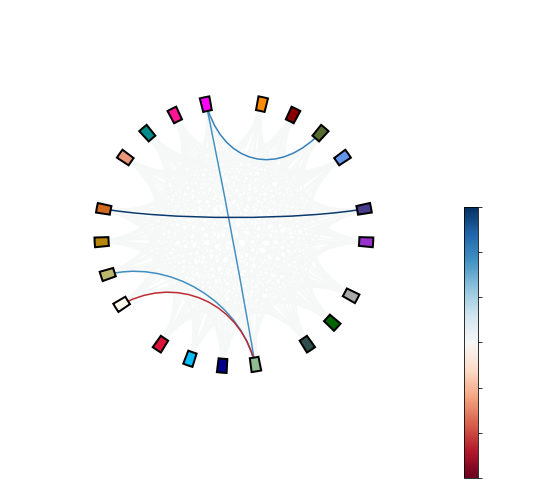

eating_disorder 1


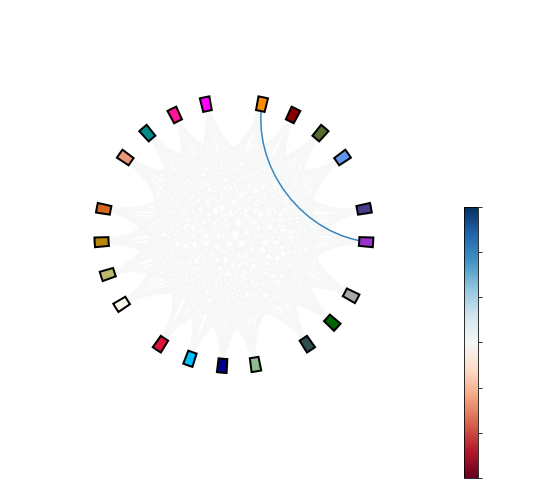

MDD 11


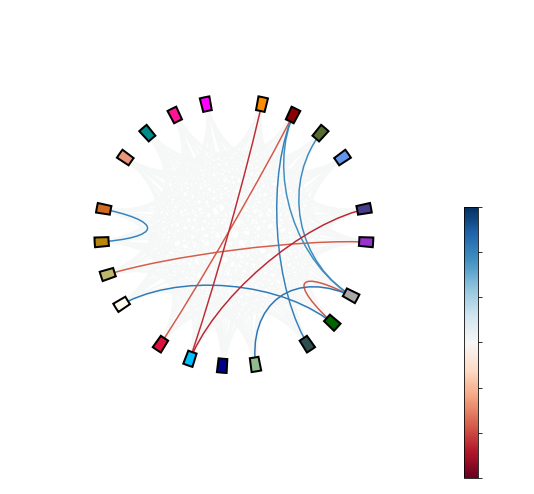

schizophrenia 43


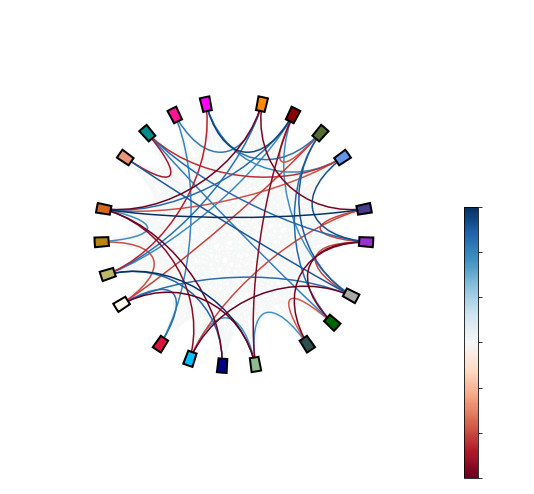

cigarettes_per_day 1


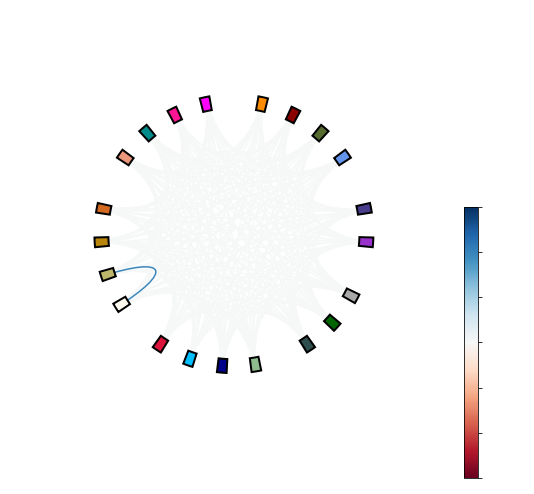

smoking_initiation 1


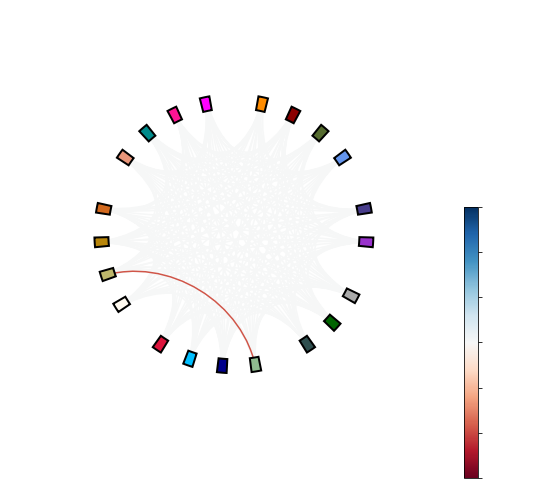

smoking_cessation 1


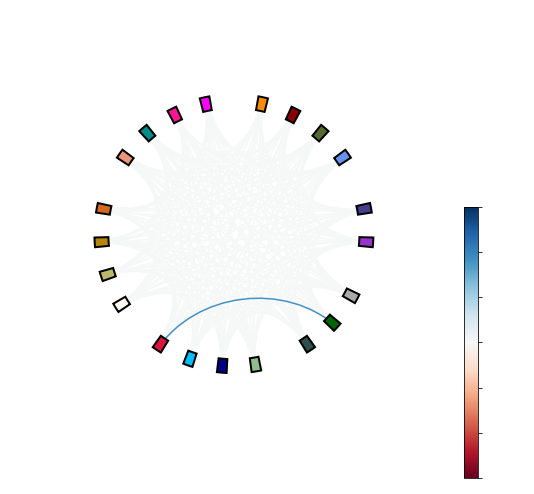

caffeine 2


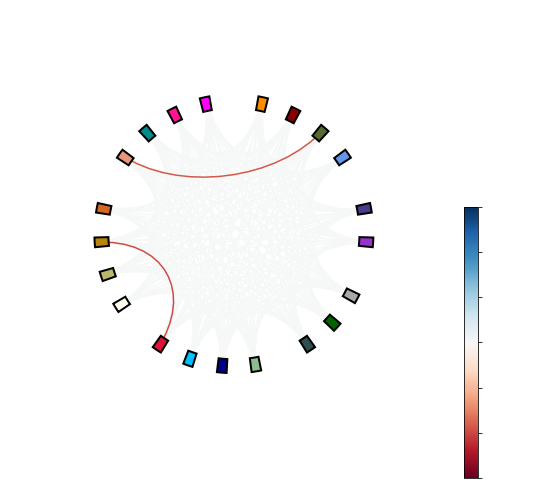

drinks_per_week 2


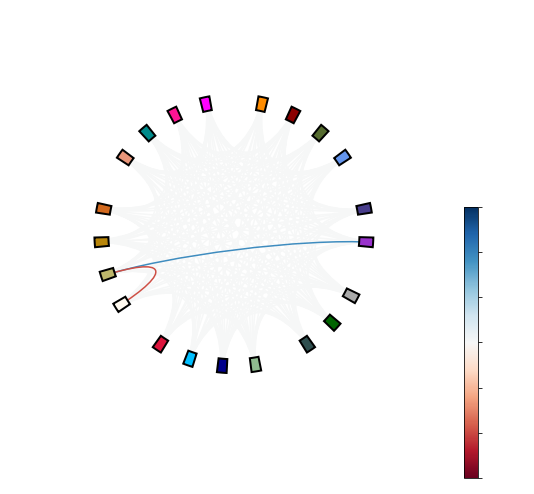

cognitive_ability 5


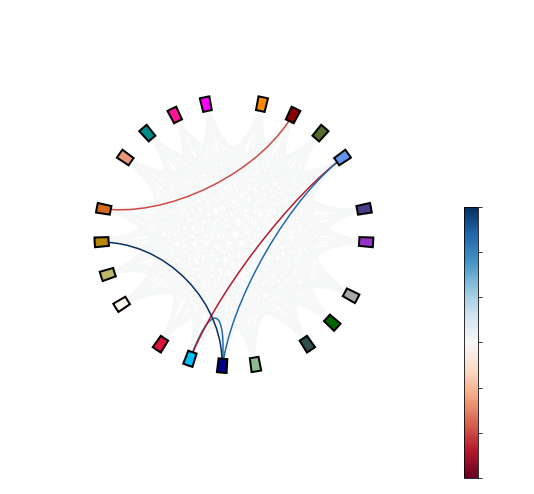

educational_attainment 46


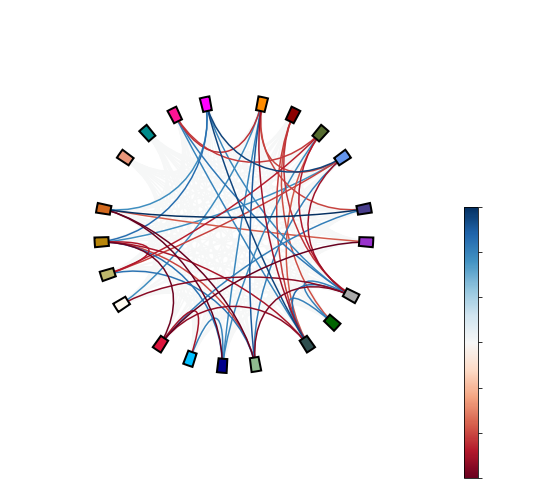

In [30]:
path1 = 'results/functional_measures/figures/'
FC_info = pd.read_csv('raw_data/edge_list_d25.txt',sep=' ')
node_order =[2,4,8,19,1,9,13,14,5,6,7,20,10,11,12,17,21,3,15,18,16]
boundaries = [0,4,8,12,15,17]
node_angles = circular_layout(label_names, node_order, start_pos=90, group_boundaries=boundaries)
# cmaps = ['RdBu','Reds','Blues']
for i in range(X.shape[1]):
    temp_R = R[i,:210]
    temp_P = correct_P[i,:210]
    FC_matrix = np.zeros((21,21))
    FC_num = np.sum(temp_P<0.0167)
    print(PRS_names[i],FC_num)
    if FC_num == 0:
        continue
    for j in range(210):
        if temp_P[j] < 0.0167:
            x = FC_info.iloc[j,1] - 1
            y = FC_info.iloc[j,2] - 1
            FC_matrix[x,y] = temp_R[j]
            FC_matrix[y,x] = temp_R[j]
             
    fig = plt.figure(figsize=(10,10))    
#     ax = plot_connectivity_circle(FC_matrix, label_names, vmin = -0.03, vmax = 0.03, facecolor = 'white', textcolor = 'black',
#                          node_angles=node_angles, node_colors=selected_colors, colormap='RdBu', fig=fig,colorbar_size=0.5,
#                          fontsize_colorbar=14,fontsize_names=14)
    ax = plot_connectivity_circle(FC_matrix, label_names, vmin = -0.03, vmax = 0.03, facecolor = 'white', textcolor = 'white',
                         node_angles=node_angles, node_width = 4, node_colors=selected_colors, colormap='RdBu', fig=fig,colorbar_size=0.5,
                         fontsize_colorbar=14,fontsize_names=14)
    output_path = os.path.join(path1,PRS_names[i]+'.png')
    fig.savefig(output_path,dpi=300,bbox_inches = 'tight') 

In [32]:
node_R = R[:,210:]
node_P = P[:,210:]
node_P_corrected = correct_P[:,210:]
re_node_R = pd.DataFrame(data=node_R)
re_node_P = pd.DataFrame(data=node_P)
re_node_P_corrected = pd.DataFrame(data=node_P_corrected)
re_node_R.to_csv('results/functional_measures/nodes_R.csv',index=False,header=None)
re_node_P.to_csv('results/functional_measures/nodes_P.csv',index=False,header=None)
re_node_P_corrected.to_csv('results/functional_measures/nodes_P_corrected.csv',index=False,header=None)